In [12]:
import numpy
%matplotlib inline
from matplotlib import pyplot

In [25]:
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle
import numpy
# interactive backends
_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
    def wrapper(*args, **kwargs):
        rc('font', family='serif', size=fontsize)
        rc('figure', dpi=200)
        rc('axes', axisbelow=True, titlesize=5)
        rc('lines', linewidth=1)
        func(*args, **kwargs)
    return wrapper



def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.
    
    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.
    
    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.
    
    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

    '''   
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."  
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)
    
    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins
    
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue, 
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)
    
    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')


def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.

    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors. 
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    title: str, optional.
        Title of the plot.

    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)
        
    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)
    
    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)


def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
    plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')


def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.

    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
      
    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

    for i in range(nplots):  # fig_idx 
        if i == 0:
            matrix_trans = numpy.identity(2)
            title = 'Before transformation'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'After {} transformation'.format(i)
            else:
                title = 'After {} transformations'.format(i)
        plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
    # hide axes of the extra subplot (only when nplots is an odd number)
    if nx*ny > nplots:
        axes[-1,-1].axis('off')
        

def plot_3d_transformation_helper(axis, matrix, grid=True, unit_sphere=False, title=None):
    """ A helper function to plot the linear transformation defined by a 3x3 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.

    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.

    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    
    title : str, optional.
        Title of the plot.

    """
    assert matrix.shape == (3,3), "the input matrix must have a shape of (3,3)"
    xcolor, ycolor, zcolor = '#0084b6', '#d8a322', '#FF3333'
    linewidth = 0.7
    if grid:
        grid_range = 2
        x = numpy.arange(-grid_range, grid_range+1)
        X, Y, Z = numpy.meshgrid(x,x,x)
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        for i in range(x.size):
            for j in range(x.size):
                axis.plot(X_new[:,i,j], Y_new[:,i,j], Z_new[:,i,j], color=xcolor, linewidth=linewidth)
                axis.plot(X_new[i,:,j], Y_new[i,:,j], Z_new[i,:,j], color=ycolor, linewidth=linewidth)
                axis.plot(X_new[i,j,:], Y_new[i,j,:], Z_new[i,j,:], color=zcolor, linewidth=linewidth)
    
    if unit_sphere:
        u = numpy.linspace(0, 2 * numpy.pi, 100)
        v = numpy.linspace(0, numpy.pi, 100)
        X = 1 * numpy.outer(numpy.cos(u), numpy.sin(v))
        Y = 1 * numpy.outer(numpy.sin(u), numpy.sin(v))
        Z = 1 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        axis.plot_surface(X_new, Y_new, Z_new, rstride=4, cstride=4, linewidth=0, cmap='ocean', alpha=0.6)

    if title is not None:
        axis.set_title(title)
    
    limit = 0
    if grid or unit_sphere:
        for array in (X_new, Y_new, Z_new):
            limit_ = numpy.max(numpy.abs(array))
            limit = max(limit, limit_)
    else:
        limit = 1
    axis.set_xlim(-limit, limit)
    axis.set_ylim(-limit, limit)
    axis.set_zlim(-limit, limit)
    # adjust the whitespace between ticks and axes to get a tighter plot
    for axis_str in ['x', 'y', 'z']:
        axis.tick_params(axis=axis_str, pad=-3)


def plot_3d_linear_transformation(matrix, grid=True, unit_sphere=False):
    """ Plot the linear transformation defined by a 3x3 matrix using the helper
    function plot_3d_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.

    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.

    """
    
    figsize = numpy.array([4,2]) * fig_scale
    figure = pyplot.figure(figsize=figsize)
    axis1 = figure.add_subplot(1, 2, 1, projection='3d')
    axis2 = figure.add_subplot(1, 2, 2, projection='3d')
    plot_3d_transformation_helper(axis1, numpy.identity(3), grid=grid, unit_sphere=unit_sphere, title='before transformation')
    plot_3d_transformation_helper(axis2, matrix, grid=grid, unit_sphere=unit_sphere, title='after transformation')


def plot_3d_linear_transformations(*matrices, grid=False, unit_sphere=False):
    """ Plot the linear transformation defined by a sequence of n 3x3 matrices using the helper
    function plot_3d_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 3x3 matrices to visualize. Accept any number of matrices. 

    grid : bool, optional.
        Whether to plot 3d grid lines, default to False.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.

    """
    nplots = len(matrices) + 1
    nx = 2                 # number of figures per row
    ny = ceil(nplots/nx)   # number of figures per column
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure = pyplot.figure(figsize=figsize)

    for i in range(nplots):  # fig_idx
        axis = figure.add_subplot(ny, nx, i+1, projection='3d')
        if i == 0:
            matrix_trans = numpy.identity(3)
            title = 'Before transformation'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'After {} transformation'.format(i)
            else:
                title = 'After {} transformations'.format(i)
        plot_3d_transformation_helper(axis, matrix_trans, grid=grid, unit_sphere=unit_sphere, title=title)


def plot_basis_helper(axis, I, J, *vectors, title=None, I_label='i', J_label='j'):
    """ A helper function to plot the 2D coordinate system determined by the basis I,J.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.

    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    
    I_label, J_label : str, optional.
        Label of the new basis, default to 'i' and 'j'.
    
    title: str, optional.
        Title of the plot.

    """
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)   # grid coordinates on the new basis
    X = I[0]*X_ + J[0]*Y_   # grid coordinates on the standard basis
    Y = I[1]*X_ + J[1]*Y_
    
    # draw origin
    origin = numpy.zeros(1)
    axis.scatter(origin, origin, c='black', s=3)

    # draw grid lines of the new coordinate system
    lw_grid = 0.4
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=grey, lw=lw_grid)
        axis.plot(X[:,i], Y[:,i], c=grey, lw=lw_grid)
    
    # highlight new axes (spines)
    lw_spine = 0.7
    zero_id = numpy.where(x==0)[0][0]
    axis.plot(X[zero_id,:], Y[zero_id,:], c=gold, lw=lw_spine)
    axis.plot(X[:,zero_id], Y[:,zero_id], c=lightblue, lw=lw_spine)

    # draw basis vectors using quiver plot
    axis.quiver(origin, origin, [I[0]], [I[1]], color=gold, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=lightblue, **quiver_params)

    # draw input vector on new coordinate system
    bound = 5
    if vectors:
        for vector in vectors:
            M = numpy.transpose(numpy.vstack((I,J)))
            vector = M @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector[0]], [vector[1]], color=red, **quiver_params)
            bound = max(ceil(numpy.max(numpy.abs(vector))), bound)
    
    # hide frames, set xlimit & ylimit, set title
    axis.set_xlim([-bound, bound])
    axis.set_ylim([-bound, bound])
    axis.axis('off')
    if title is not None:
        axis.set_title(title)

    # add text next to new basis vectors
    text_params = {'ha': 'center', 'va': 'center', 'size' : 6}
    axis.text((I[0]-J[0])/2*1.1, (I[1]-J[1])/2*1.1, r'${}$'.format(I_label), color=gold, **text_params)
    axis.text((J[0]-I[0])/2*1.1, (J[1]-I[1])/2*1.1, r'${}$'.format(J_label), color=lightblue, **text_params)


def plot_basis(I, J, *vectors):
    """ Plot 2d vectors on the coordinates system defined by basis I and J using the helper funtion
    plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.

    """
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    plot_basis_helper(axis, I, J, *vectors)


def plot_change_basis(I, J, *vectors):
    """ Create a side-by-side plot of some vectors both on the standard basis and on the new basis
    defined by I and J, using the helper function plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.

    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    M = numpy.transpose(numpy.vstack((I,J)))
    M_inv = inv(M)
    vectors_ = [ M_inv @ vector.reshape(-1, 1) for vector in vectors ]
    plot_basis_helper(axis1, numpy.array([1,0]), numpy.array([0,1]), *vectors, title='standard basis')
    plot_basis_helper(axis2, I, J, *vectors_, title='new basis', I_label='a', J_label='b')


def plot_eigen(matrix):
    """ Visualize the eigendecomposition of a 2x2 matrix as a combination of changing basis 
    and scaling transformation, using the helper function plot_basis_helper().

    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    """
    figsize = numpy.array([4,4]) * fig_scale
    figure, axes = pyplot.subplots(2, 2, figsize=figsize)
    
    eigenvalues, eigenvectors = eig(matrix)
    C = eigenvectors
    D = numpy.diag(eigenvalues)
    C_inv = inv(C)

    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))

    plot_basis_helper(axes[0,0], numpy.array([1,0]), numpy.array([0,1]), title=r'coords in standard basis $\mathbf{x}$')
    plot_basis_helper(axes[0,1], C[:,0], C[:,1], title=r'change to new basis $C^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,0], C[:,0], C[:,1], title=r'scale along new basis $DC^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,1], numpy.array([1,0]), numpy.array([0,1]), title=r'change back to standard basis $CDC^{-1}\mathbf{x}$')

    circle_trans = matrix @ circle
    for axis in axes[0]:
        axis.plot(circle[0], circle[1], color=red, lw=0.8)
    for axis in axes[1]:
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

if __name__ == "__main__":
    pass

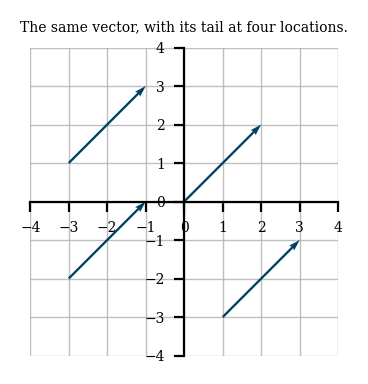

In [26]:
vectors = [(2,2)]
tails = [(-3,-2), (-3,1), (0,0), (1,-3)]
plot_vector(vectors, tails)
pyplot.title("The same vector, with its tail at four locations.");

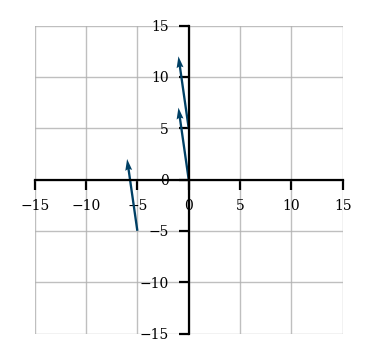

In [30]:
v_new = [(-1,7)]
t_new = [(-5,-5), (0,5), (0,0)]
plot_vector(v_new, t_new)

### Vector Addition

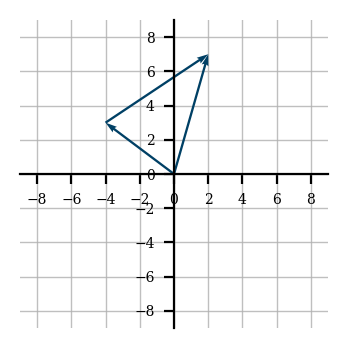

In [35]:
v1 = numpy.array((-4,3))
v2 = numpy.array((6,4))
v_sum = v1+v2
origin = numpy.array((0,0))
vectors=[v1, v2, v_sum]
tails = [origin, v1, origin]
plot_vector(vectors, tails)

### Scaling of vector

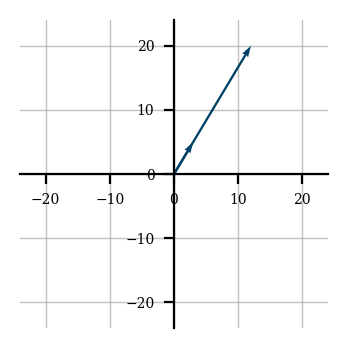

In [37]:
v = numpy.array((3,5))
scaled_v = 4*v
vectors=[scaled_v, v]
plot_vector(vectors)

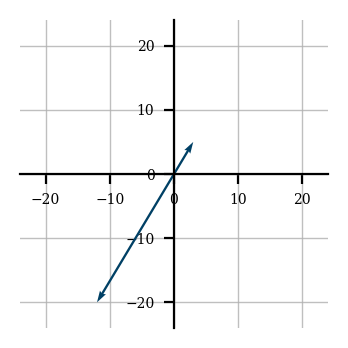

In [39]:
# multiplying by negative scalar
v = numpy.array((3,5))
scaled_v = -4*v
vectors=[scaled_v, v]
plot_vector(vectors)

### Basis Vectors